In [10]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
# import audiomentations
# from audiomentations import Compose, AddGaussianNoise, PitchShift
# import torch_audiomentations
# from torch_audiomentations import Compose, AddGaussianNoise, PitchShift
import torchaudio

In [11]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio
class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device,
                 augment=False,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'symptomatic':1, 'COVID-19':2}
        
        self.do_augment = augment
#         self.augmentations = Compose(
#                 [
#                     AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.05, p=0.5),
#                     PitchShift(min_semitones=-8, max_semitones=8, p=0.5)
#                 ]
#         )

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)
        
#         if self.do_augment:
#             signal = torch.from_numpy(self.augmentations(signal.numpy(), sr))
        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]


In [12]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
# print(f"Using device {device}")

# train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train.parquet.gzip"))
# val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val.parquet.gzip"))
# test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test.parquet.gzip"))

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_edited.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))

# print(f"There are {len(usd)} samples in the dataset.")
# signal, label = usd[0]

In [ ]:
dataset[0][0].shape

In [13]:
class CNNNetwork(torch.nn.Module):

    def __init__(self, drop_p=0.2):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_p)

        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=drop_p)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=drop_p)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=drop_p)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(31744, 3)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_data):
        #nomralization
        std = input_data.std()
        input_data -= input_data.mean()
        input_data /= std
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions
    



In [14]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device):
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        
    print(f"Training loss: {total_loss}, Training accuracy : {correct_pred/total_pred}")
    
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() 
            
        correct_pred += count_correct(y_pred, y_batch)
        total_pred += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss}, Validation accuracy : {correct_pred/total_pred}")

    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")
    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()
        
    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    print("---------------------------")

In [15]:
BATCH_SIZE =16
EPOCHS = 10
MODEL_FOLDER = '../models/'

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = create_data_loader(train_data, BATCH_SIZE)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)
test_dataloader = create_data_loader(val_data, BATCH_SIZE)

# construct model and assign it to device
model = CNNNetwork().to(device)

# initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

---------------------------------------------------------------------------------------------------------------------------------------------Serena: Data Processing

Get all the bad wav files.

In [12]:

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train.parquet.gzip"))
all_df = pd.read_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid.parquet.gzip"))
# loop through all samples and load
error_files = []
error_labels = []
for i in tqdm(range(len(all_df))):
    path = os.path.join(AUDIO_DIR, all_df.iloc[i, 0])+".wav"
    label = all_df.iloc[i, 9]
    try:
        audio, sr = torchaudio.load(path)
    except:
        #print(f"Error loading {path}")
        error_files.append(path)
        error_labels.append(label)


100%|██████████| 13535/13535 [00:31<00:00, 434.77it/s]


Count how many bad wav files there are

In [13]:
print('Number of bad wav files in all:', len(error_files))
#count how many of each label
healthy = 0
covid = 0
symptomatic = 0
for label in error_labels:
    if label == 'healthy':
        healthy += 1
    elif label == 'COVID-19':
        covid += 1
    elif label == 'symptomatic':
        symptomatic += 1
print('Number of bad healthy samples:', healthy)
print('Number of bad covid samples:', covid)
print('Number of bad symptomatic samples:', symptomatic)


#write error_files to csv
with open('error_files.csv', 'w') as f:
    for item in error_files:
        f.write(item[14:-4])
        f.write('\n')

Number of bad wav files in all: 788
Number of bad healthy samples: 475
Number of bad covid samples: 20
Number of bad symptomatic samples: 293


Try reconverting all the bad wav files -- found that they are all existing wav files in the folders.

In [ ]:
import subprocess


coughvid = '../../coughvid_20211012/'
current_dir = os.getcwd()

#read in error files in pd
error_files = pd.read_csv('error_files.csv', header=None)
#cut off the front and .wav at the end
test = error_files[0].str[14:-4]

count = 0
for file in tqdm(test):
# run ffmpeg -i "file.webm" -vn "file.wav" in terminal to convert to wav
    print(coughvid + file + '.webm')
    if os.path.isfile(coughvid + file + '.webm'):
        subprocess.call(["ffmpeg", "-i", coughvid+file+".webm", current_dir+'./temp_wav/'+file+".wav"])
    elif os.path.isfile(coughvid + file + '.ogg'):
        subprocess.call(["ffmpeg", "-i", coughvid+file+".ogg", current_dir+'./temp_wav/'+file+".wav"])
    else:
        print("Error: No file name {0}".format(file))
        count += 1
print(count)

Create the new data without the bad wav files

In [9]:
all_df = pd.read_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid.parquet.gzip"))
# for each file name in error files
# remove it from all_df
# create new train/test split


#read in error files in pd
error_files = pd.read_csv('error_files.csv', header=None)

#for each file name in error files
#remove it from all_df
# create new train/test split
for file in tqdm(error_files[0]):
    #if file equals uuid in all_df remove it from all_df
    #remove row from all_df
    all_df = all_df.drop(all_df.index[all_df['uuid'] == file])

#save new all_df
all_df.to_parquet(os.path.join(AUDIO_DIR, "metadata_compiled_valid_edited.parquet.gzip"))
#save new all_df as csv
all_df.to_csv(os.path.join(AUDIO_DIR, "metadata_compiled_valid_edited.csv"))



100%|██████████| 788/788 [00:06<00:00, 130.51it/s]


Serena: Data Processing End
---------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS)

Epoch 1


100%|██████████| 646/646 [01:54<00:00,  5.65it/s]


Training loss: 534.3469835519791, Training accuracy : 0.7233630418777466


100%|██████████| 72/72 [00:11<00:00,  6.25it/s]


Validataion loss: 59.077050268650055, Validation accuracy : 0.7299651503562927
Saved at ../models/epoch_0.pth
---------------------------
Epoch 2


100%|██████████| 646/646 [01:54<00:00,  5.63it/s]


Training loss: 518.97364538908, Training accuracy : 0.7477721571922302


100%|██████████| 72/72 [00:11<00:00,  6.31it/s]


Validataion loss: 57.54184144735336, Validation accuracy : 0.7517421841621399
Saved at ../models/epoch_1.pth
---------------------------
Epoch 3


100%|██████████| 646/646 [01:57<00:00,  5.51it/s]


Training loss: 517.2776116132736, Training accuracy : 0.75019371509552


100%|██████████| 72/72 [00:11<00:00,  6.28it/s]


Validataion loss: 57.03735435009003, Validation accuracy : 0.7587108016014099
Saved at ../models/epoch_2.pth
---------------------------
Epoch 4


100%|██████████| 646/646 [01:55<00:00,  5.57it/s]


Training loss: 516.3263672590256, Training accuracy : 0.751840353012085


100%|██████████| 72/72 [00:10<00:00,  6.57it/s]


Validataion loss: 57.12068718671799, Validation accuracy : 0.7578397393226624
Saved at ../models/epoch_3.pth
---------------------------
Epoch 5


100%|██████████| 646/646 [01:57<00:00,  5.51it/s]


Training loss: 513.6064985990524, Training accuracy : 0.7561022639274597


100%|██████████| 72/72 [00:10<00:00,  6.62it/s]


Validataion loss: 56.99568712711334, Validation accuracy : 0.7595818638801575
Saved at ../models/epoch_4.pth
---------------------------
Epoch 6


100%|██████████| 646/646 [02:11<00:00,  4.93it/s]


Training loss: 513.4895613789558, Training accuracy : 0.7562960386276245


100%|██████████| 72/72 [00:12<00:00,  5.72it/s]


Validataion loss: 57.37068724632263, Validation accuracy : 0.7543553709983826
Saved at ../models/epoch_5.pth
---------------------------
Epoch 7


100%|██████████| 646/646 [02:00<00:00,  5.37it/s]


Training loss: 513.5343533754349, Training accuracy : 0.7561991214752197


100%|██████████| 72/72 [00:11<00:00,  6.36it/s]


Validataion loss: 57.360287606716156, Validation accuracy : 0.7543553709983826
Saved at ../models/epoch_6.pth
---------------------------
Epoch 8


100%|██████████| 646/646 [01:58<00:00,  5.47it/s]


Training loss: 514.170517206192, Training accuracy : 0.7552305459976196


100%|██████████| 72/72 [00:11<00:00,  6.34it/s]


Validataion loss: 57.31188726425171, Validation accuracy : 0.7552264928817749
Saved at ../models/epoch_7.pth
---------------------------
Epoch 9


100%|██████████| 646/646 [02:02<00:00,  5.29it/s]


Training loss: 514.0994479060173, Training accuracy : 0.7553274035453796


100%|██████████| 72/72 [00:11<00:00,  6.30it/s]


Validataion loss: 57.05819469690323, Validation accuracy : 0.7587108016014099
Saved at ../models/epoch_8.pth
---------------------------
Epoch 10


100%|██████████| 646/646 [01:59<00:00,  5.41it/s]


Training loss: 513.6010187268257, Training accuracy : 0.7561022639274597


100%|██████████| 72/72 [00:11<00:00,  6.27it/s]

Validataion loss: 57.18318724632263, Validation accuracy : 0.75696861743927
Saved at ../models/epoch_9.pth
---------------------------
Finished training
---------------------------


In [18]:
evaluate(model, test_dataloader, loss_fn, device)

Evaluating model


100%|██████████| 72/72 [00:11<00:00,  6.23it/s]

Evaluation loss: 57.12068724632263, Evaluation accuracy : 0.7578397393226624
---------------------------


In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [22]:
from sklearn.metrics import plot_confusion_matrix

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # calculate loss
            y_pred = model(x_batch)


            trues += torch.clamp(y_batch, max=1)


            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)
            
            
    return np.array(trues), np.array(preds)
        




In [23]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|██████████| 72/72 [00:12<00:00,  5.92it/s]


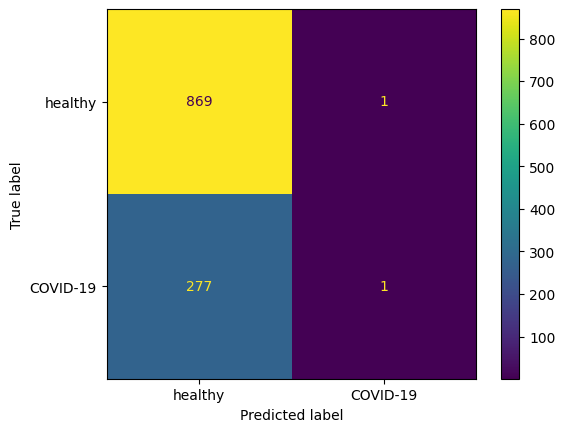

In [26]:
cfm = confusion_matrix(trues, preds)
#ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'symptomatic', 'COVID-19']).plot()
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'COVID-19']).plot()

In [64]:
cfm

NameError: name 'cfm' is not defined

In [73]:
preds.dtype

dtype('int64')